# Lecture 5: Confidence Intervals Based on the Assumption of Normality or the Central Limit Theorem

## Today's Learning Goals

By the end of this lecture, you should be able to:

1. Explain the Central Limit Theorem and its role in constructing confidence intervals.
2. Describe a Normal distribution.
3. Write a computer script to calculate confidence intervals based on the assumption of normality or the Central Limit Theorem.
4. Discuss the potential limitations of these methods.

## Loading `R` Packages

Let us load the libraries for data wrangling, analysis, and plotting.

In [1]:
library(tidyverse)
library(infer)
library(cowplot)
options(repr.matrix.max.rows = 6)
options(repr.plot.width = 8, repr.plot.height = 6)

── Attaching packages ─────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.0      ✔ stringr 1.4.0 
✔ readr   2.1.2      ✔ forcats 0.5.1 

── Conflicts ────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



## 1. What simulation has taught us about sampling distributions of sample estimates?

Let us revisit the concepts of population and sampling distributions we discussed in `lecture1`. Specifically, we will dig into the sampling distribution of the sample mean $\bar{X}$ (an **estimator**!) with different sample sizes $n$.

### 1.1. Introduction to Vancouver Property Tax Data

> "In this world, nothing is certain except death and taxes." <br> [Benjamin Franklin](https://constitutioncenter.org/blog/benjamin-franklins-last-great-quote-and-the-constitution)

Homeowners in Vancouver can certainly agree with the statement above. Every year, Vancouverites have their property assessed for its value, and based on that, are charged a certain amount to the government as a tax for owning property.

For several years, the City of Vancouver has collected data on the assessment and levy for every property in Vancouver. This data has been made publicly available on their [Data Portal](https://opendata.vancouver.ca/), and we have compiled it into an `R` package called `taxyvr`. 

In [2]:
library(taxyvr)

Library `taxyvr` contains property tax assessment data for all properties from 2014 to 2019, with one data frame for each year, named `tax_2014`, `tax_2015`, and so on.

For this example, we will be looking at the data from 2019, i.e., `tax_2019`.

```{attention}
The `tax_2019` dataset represents all the properties in Vancouver for the year 2019 **and can be considered a census**. This census characteristic will be necessary for exploring the inferential concepts in this lecture. Note that having census data is not common in most real-life cases, for which we would need to collect a random sample and perform statistical inference.
``` 

**Our population of interest is a subset of all Vancouver properties**, so we need to select only the rows for this type of property. The code below shows all the variables in the raw population data `tax_2019`.

In [3]:
str(tax_2019)

tibble [213,182 × 32] (S3: tbl_df/tbl/data.frame)
 $ pid                       : chr [1:213182] "010-862-706" "010-863-915" "010-863-923" "010-863-931" ...
 $ legal_type                : chr [1:213182] "LAND" "LAND" "LAND" "LAND" ...
 $ folio                     : num [1:213182] 1.96e+10 1.96e+10 1.96e+10 1.96e+10 1.96e+10 ...
 $ land_coordinate           : num [1:213182] 1963206 1963229 1963245 1963265 1963276 ...
 $ zone_name                 : chr [1:213182] "RS-1" "RS-1" "RS-1" "RS-1" ...
 $ zone_category             : chr [1:213182] "One Family Dwelling" "One Family Dwelling" "One Family Dwelling" "One Family Dwelling" ...
 $ block                     : chr [1:213182] "2" "3" "3" "3" ...
 $ plan                      : chr [1:213182] "VAP6583" "VAP6583" "VAP6583" "VAP6583" ...
 $ district_lot              : chr [1:213182] "140" "140" "140" "140" ...
 $ lot                       : chr [1:213182] "22" "8" "9" "10" ...
 $ from_civic_number         : chr [1:213182] NA NA NA NA ...
 $ to

### 1.2. Population of Interest and Data Wrangling

Note we are only interested in the population corresponding to multiple-family dwellings in strata housing. Specifically, we will check the **current land value**.

Therefore, in `tax_2019`, we will focus on the following population of properties that meet the following criteria:

- **A land value in CAD greater than \$1 (i.e., not `NA` nor \$0):** Some properties are assigned a value of `NA`, and these are the properties undergoing extensive renovations. These values get amended after the improvement and are reflected in the following year's assessment. The same occurs with homes that are assessed at $0.
- **A legal type land `STRATA`.**
- **A zone category `Multiple Family Dwelling`.**

As in any **parent population distribution**, we have a population mean $\mu$ and standard deviation $\sigma$ (note that this greek letter notation can also be used for non-Normal distributions).

Therefore, let $N$ be the population size. Furthermore, let $x_1, x_2, \dots, x_N$ (note these are actual values, not random variables!) be the data points belonging to this population. The respective mean and standard deviation are

$$\mu = \sum_{i = 1}^N \frac{x_i}{N}$$

$$\sigma = \sqrt{\frac{1}{N} \sum_{i = 1}^N (x_i - \mu)^2}.$$

Let $X_1, X_2, \dots, X_n$ be a random sample of *iid* elements of size $n$ (note the random variable notation in uppercases). Assume this random sample comes from the **parent population** with mean $\mu$ and standard deviation $\sigma$.

Recall that the sample mean and standard deviation are respectively:

$$\bar{X} = \sum_{i = 1}^n \frac{X_i}{n}$$

$$S = \sqrt{\frac{1}{n - 1} \sum_{i = 1}^n (X_i - \bar{X})^2}.$$

First off, given that $\mathbb{E}(X_i) = \mu$, then:

$$\mathbb{E}(\bar{X}) = \mathbb{E} \left( \sum_{i = 1}^n \frac{X_i}{n} \right) = \mu.$$

You might be surprised on the factor $\frac{1}{N}$ in the equation for $\sigma$ and the $\frac{1}{n - 1}$ for $S^2$. It turns out that the factor $\frac{1}{n - 1}$ makes the **sample variance $S^2$** an **unbiased estimator** for the population variance $\sigma^2$ (assuming a random sample of *iid* elements). This fact is translated as:

$$\mathbb{E}(S^2) = \mathbb{E} \left[ \frac{1}{n - 1} \sum_{i = 1}^n (X_i - \bar{X})^2 \right] = \sigma^2.$$

```{note}
We will skip the proof for the above equation. This will be a challenging exercise in `lab3`.
```

For this population of interest let us compute $\mu$ and $\sigma$. We can see that $N = 23173$.

In [4]:
multi_family_strata_pop <- tax_2019 %>%
  filter(
    !is.na(current_land_value),
    current_land_value > 1,
    legal_type == "STRATA",
    zone_category == "Multiple Family Dwelling"
  ) %>%
  select(current_land_value)
N <- nrow(multi_family_strata_pop) # Population size

multi_family_strata_pop

current_land_value
<dbl>
1052000
984000
984000
⋮
268000
214000
252000


We can see that $\mu = 620331.5$.

In [5]:
pop_mean_land_value <- multi_family_strata_pop %>%
  summarize(pop_mean_price = round(mean(current_land_value), 2))
pop_mean_land_value

pop_mean_price
<dbl>
620331.5


Then, $\sigma = 449099.5$ (quite large, but not surprising since it is Vancouver's real state).

In [6]:
pop_sd_land_value <- multi_family_strata_pop %>%
  summarize(pop_sd_land_value = round(sd(current_land_value), 2))
pop_sd_land_value <- sqrt(((N - 1) / N)) * pop_sd_land_value # sd() has 1/N-1 by default
pop_sd_land_value

pop_sd_land_value
<dbl>
449099.5


### 1.3. Population Data Visualization

Recall our population of interest is `multi_family_strata_pop`: properties in Vancouver of legal type land `STRATA` and zone category `Multiple Family Dwelling` **that are not undergoing extensive renovations**.

Now, let us visualize the **population distribution** for **current land value**. Note it is heavily right-skewed.

In [7]:
# Setting up plot width and height.
options(repr.plot.width = 15, repr.plot.height = 8)

pop_price_dist <- ggplot(multi_family_strata_pop, aes(x = current_land_value)) +
  geom_histogram(fill = "dodgerblue3", color = "lightgrey", bins = 60) +
  labs(x = "Current Land Value (CAD)", y = "Count") +
  theme(text = element_text(size = 16.5)) +
  geom_vline(xintercept = 620331.5, colour = "red", size = 1.5) +
  annotate("text", x = 1750000, y = 9500, label = expression(mu["value"] ~ "= 620331.5"), size = 7, color = "red") +
  annotate("text", x = 2500000, y = 8750, label = expression(sigma["value"] ~ "= 449099.5"), size = 7, color = "darkgreen") +
  ggtitle("Population Distribution of Land Value of Vancouver's Multiple-family Dwellings in Strata Housing") 

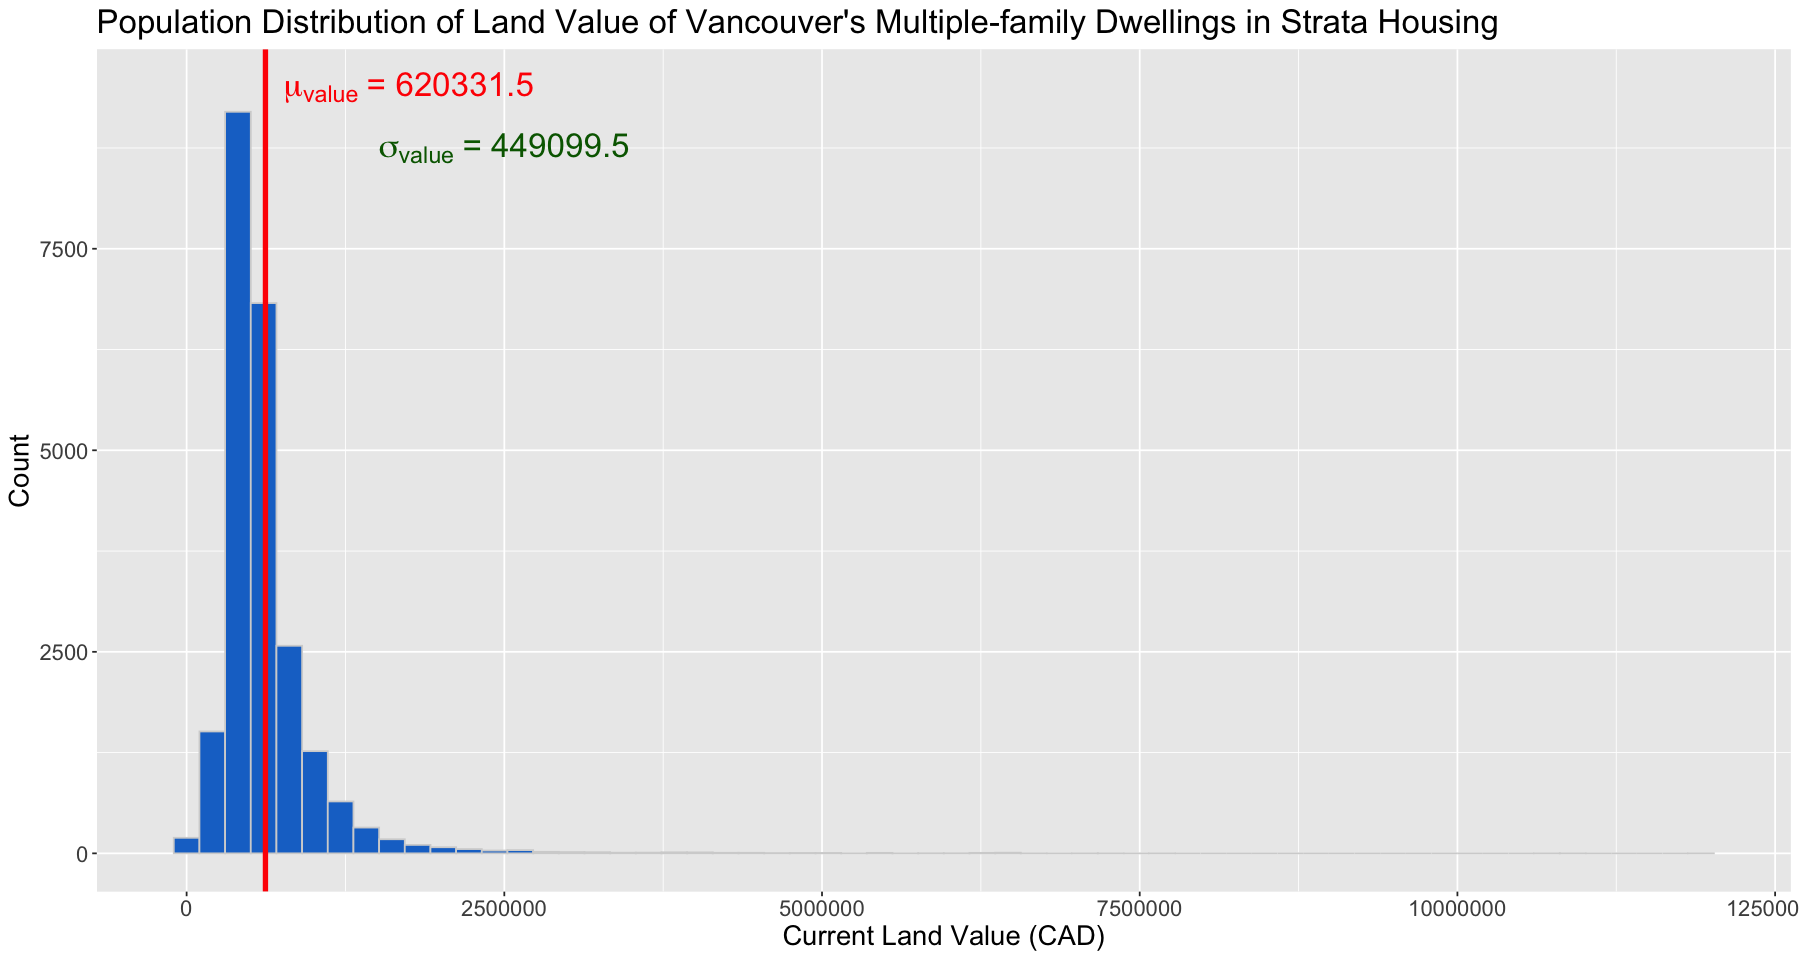

In [8]:
suppressWarnings(print(pop_price_dist))

### 1.4. Multiple Sampling

Imagine a BC realtor has hired you to help estimate the population mean housing price (i.e., the **population mean current land value**) of properties in Vancouver of legal type land `STRATA` and zone category `Multiple Family Dwelling` **that are not undergoing extensive renovations**.

Again, suppose you do not have access to the population data.

As we have done previously, we will use multiple sampling to simulate the sampling distribution of the estimator $\bar{X}$. We will do it for three different sample sizes $n = 10, 30, 100$.

We will take 5000 random samples per size $n$ **with replacement**, then calculate the respective sample means we are interested in for each sample. Finally, we will visualize the distribution of these sample point estimates. We use the following function `reveal_sampling_dist()`.

In [9]:
#' Visualize a sampling distribution of a sample estimate given a finite population.
reveal_sampling_dist <- function(sample, fun, col, sample_size, x_axis_range, x_label, nbins = 30) {
  sample %>%
    summarise(sample_estimate = fun({{ col }})) %>%
    ggplot(aes(x = sample_estimate)) +
    geom_histogram(bins = nbins) +
    xlim(x_axis_range) +
    xlab(x_label) +
    ggtitle(paste("n = ", sample_size)) +
    theme(
      text = element_text(size = 30),
      axis.text.x = element_text(angle = 60, hjust = 1)
    )
}

Then, we run our multiple sampling and run `reveal_sampling_dist()` three times.

In [10]:
set.seed(552)

samples_n10 <- rep_sample_n(multi_family_strata_pop, size = 10, reps = 5000, replace = TRUE) 
samples_n30 <- rep_sample_n(multi_family_strata_pop, size = 30, reps = 5000, replace = TRUE) 
samples_n100 <- rep_sample_n(multi_family_strata_pop, size = 100, reps = 5000, replace = TRUE) 

sampling_dist_10 <- samples_n10 %>%
  reveal_sampling_dist(
    mean,
    current_land_value,
    10,
    c(400000, 1200000),
    "Sample Mean (Land Value in CAD)"
  )

sampling_dist_30 <- samples_n30 %>%
  reveal_sampling_dist(
    mean,
    current_land_value,
    30,
    c(400000, 1200000),
    "Sample Mean (Land Value in CAD)"
  )

sampling_dist_100 <- samples_n100 %>%
  reveal_sampling_dist(
    mean,
    current_land_value,
    100,
    c(400000, 1200000),
    "Sample Mean (Land Value in CAD)"
  )

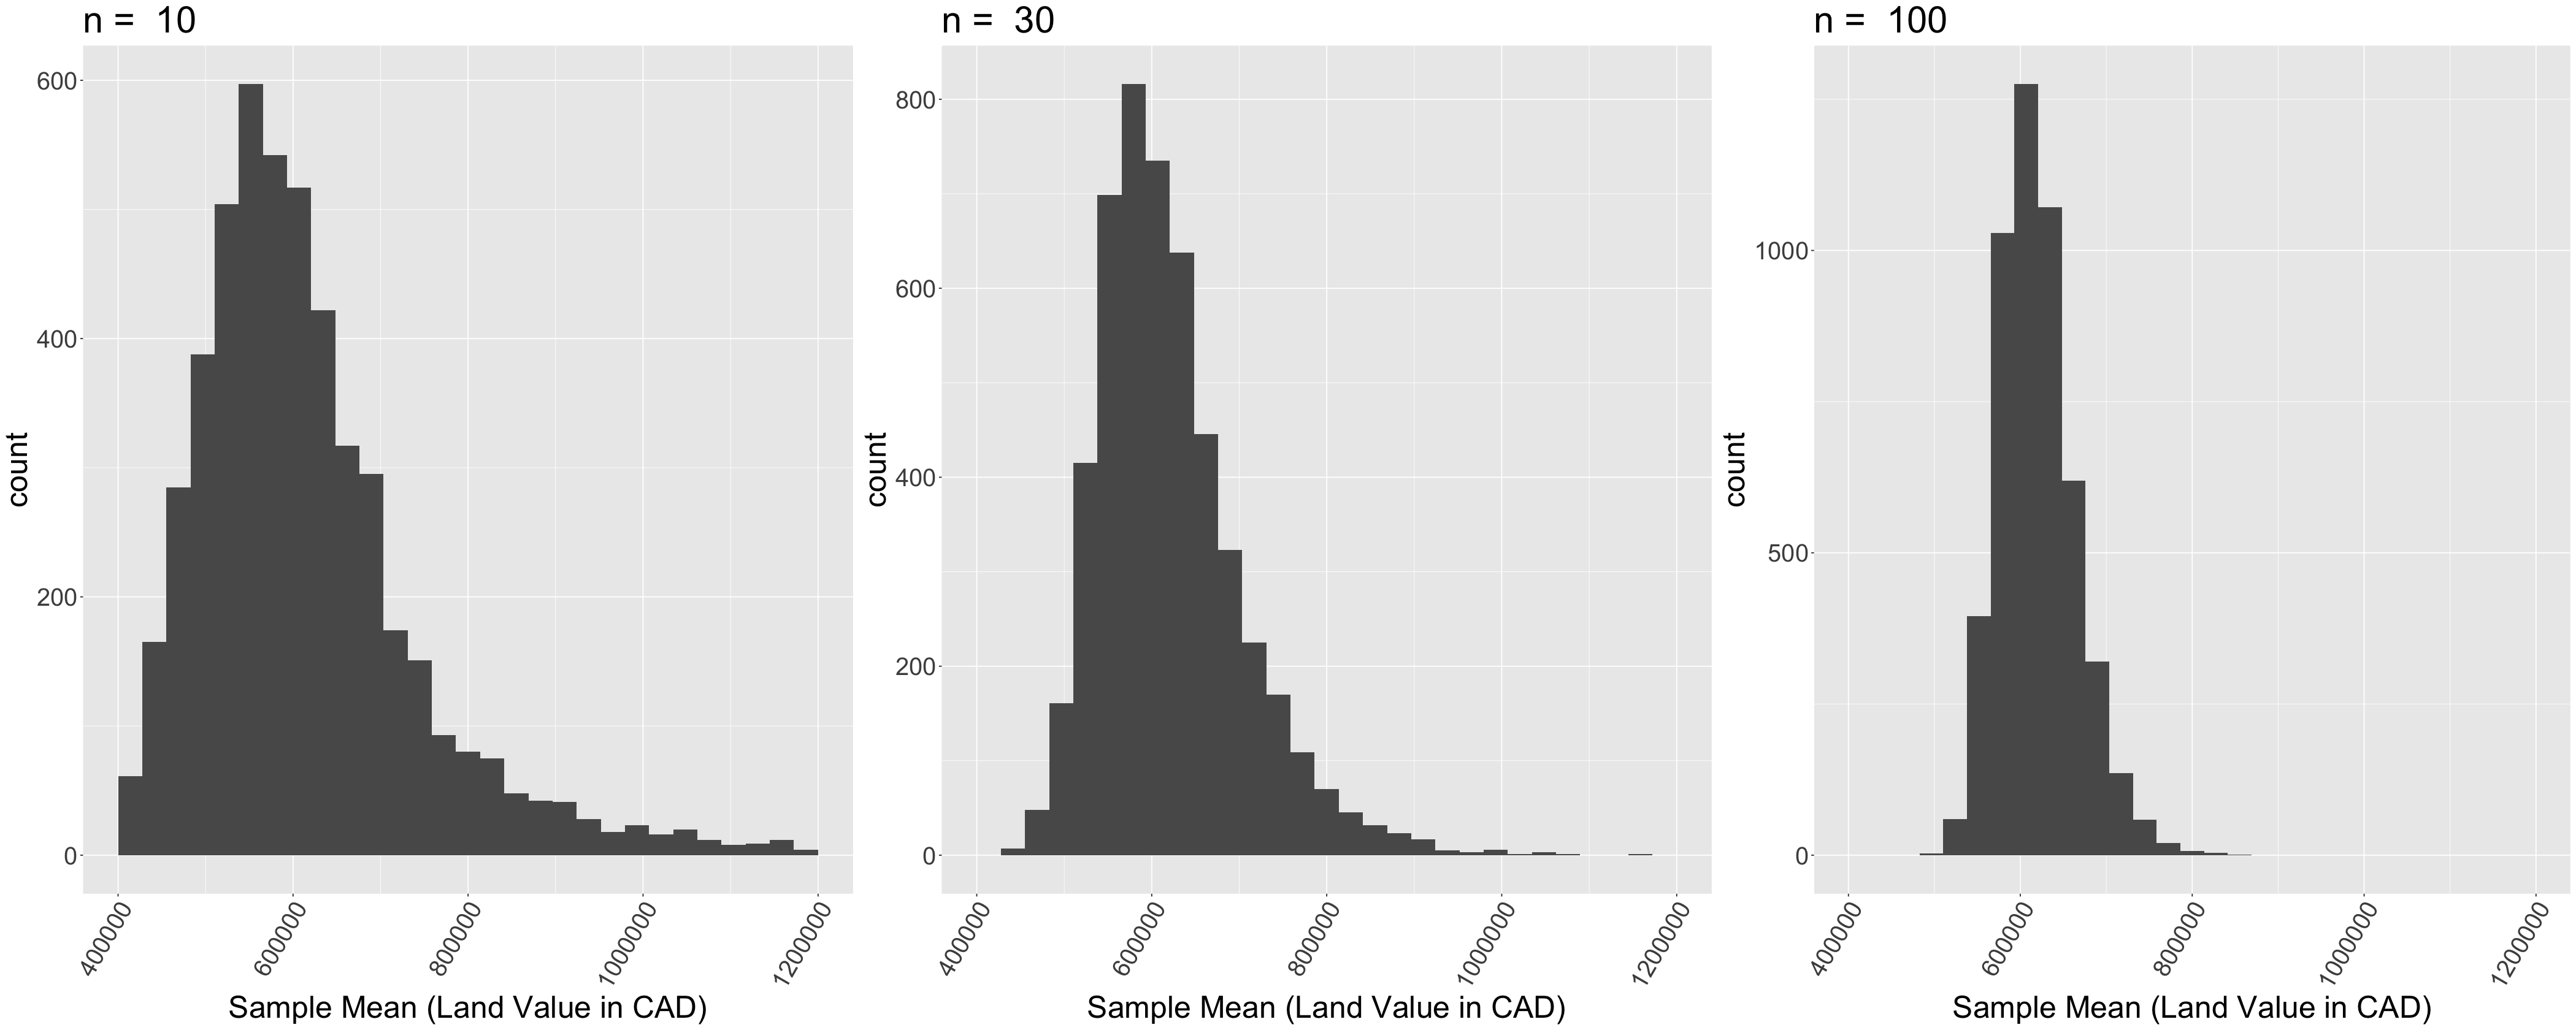

In [11]:
options(repr.plot.width = 35, repr.plot.height = 14)

suppressWarnings(print(plot_grid(sampling_dist_10, sampling_dist_30, sampling_dist_100, ncol = 3)))

Finally, let us compute the grand mean and standard error (i.e., the standard deviation of each set of 5000 sample means).

In [12]:
summary_sampling_dist_n10 <- samples_n10 %>%
  summarize(sample_mean = mean(current_land_value)) %>%
  summarize(
    grand_mean = round(mean(sample_mean), 2),
    std_error = round(sd(sample_mean), 2)
  )

summary_sampling_dist_n30 <- samples_n30 %>%
  summarize(sample_mean = mean(current_land_value)) %>%
  summarize(
    grand_mean = round(mean(sample_mean), 2),
    std_error = round(sd(sample_mean), 2)
  )

summary_sampling_dist_n100 <- samples_n100 %>%
  summarize(sample_mean = mean(current_land_value)) %>%
  summarize(
    grand_mean = round(mean(sample_mean), 2),
    std_error = round(sd(sample_mean), 2)
  )

Something really particular is happening here. For our simulation purposes, we know that $\mu = 620331.5$ and $\sigma = 449099.5$. Let $\tilde{\bar{x}}_{10}$ and $\tilde{s}_{10}$ be the observed sampling grand mean and standard error respectively for $n = 10$. Then:

In [13]:
summary_sampling_dist_n10

grand_mean,std_error
<dbl>,<dbl>
616288.5,140192.2


$$\mu = 620331.5 \approx 616288.5 = \tilde{\bar{x}}_{10}$$

$$\frac{\sigma}{\sqrt{10}} = 142017.7 \approx 140192.2 = \tilde{s}_{10}$$

For $n = 30$ with observed sampling grand mean $\tilde{\bar{x}}_{30}$ and standard error $\tilde{s}_{30}$:

In [14]:
summary_sampling_dist_n30

grand_mean,std_error
<dbl>,<dbl>
620169.8,82679.93


$$\mu = 620331.5 \approx 620169.8 = \tilde{\bar{x}}_{30}$$

$$\frac{\sigma}{\sqrt{30}} = 81993.98 \approx 82679.93 = \tilde{s}_{30}$$

For $n = 100$ with observed sampling grand mean $\tilde{\bar{x}}_{100}$ and standard error $\tilde{s}_{100}$:

In [15]:
summary_sampling_dist_n100

grand_mean,std_error
<dbl>,<dbl>
619548.7,44824.09


$$\mu = 620331.5 \approx 619548.7 = \tilde{\bar{x}}_{100}$$

$$\frac{\sigma}{\sqrt{100}} = 44909.95 \approx 44824.09 = \tilde{s}_{100}$$

**Now, think about the following:**

- What do we notice about the shape?
- What do we notice about the relationship between spread and sample size $n$?
- Do the figures and evolving shape of the histogram as we increase $n$ shed light on a particular theorem?

**Possible answers:**

- The sampling distribution is centred at the true population mean.
- Most sample means are at or very near the same value as the true population mean as we increase $n$.
- The sampling distribution of the sample means is not necessarily the same shape as the distribution of the population distribution and tends to be more symmetrical and bell-shaped.
- Both sets of figure results and plot shapes cry out the Central Limit Theorem!

## 2. The Central Limit Theorem (CLT)

**Regardless of the parent population distribution whose mean is $\mu$ and standard deviation is $\sigma$**, the Central Limit Theorem (CLT) states that the sampling distribution of the **sample mean** $\bar{X}$ converges to a Normal distribution with mean $\mu$ and standard deviation $\sigma/\sqrt{n}$ as the sample size $n$ gets larger **when we sample with replacement**.

```{attention} 
This theorem only applies to sample means!
```

The above CLT conditions can be mathematically defined as follows:

$$\bar{X} \mathrel{\dot\sim} \mathcal{N} \Bigg( \mu, \frac{\sigma}{\sqrt{n}} \Bigg) \quad \text{as} \quad n \rightarrow \infty$$

```{attention} 
The symbol $\mathrel{\dot\sim}$ indicates "*approximately distributed*".
```

```{important}
What we have observed via different simulations can also be shown/proven mathematically. **As a side note**, the [moment generating function (MGF)](https://pages.github.ubc.ca/MDS-2022-23/DSCI_551_stat-prob-dsci_students/continuous-distributions.html#other-ways-of-representing-a-distribution-optional) of a random variable and Taylor series expansions play a crucial role in this proof. Roughly speaking, the MGF is just another way of representing a statistical distribution to obtain its corresponding parameters.
```

### 2.1.  Central Limit Theorem Conditions

We have previously discussed that a random sample is composed of $n$ independent and identically distributed (*iid*) random variables $X_1, X_2, \dots X_n$. This *iid* condition needs to hold in our sampling to invoke the CLT, especially independence since some MGF properties rely on this. 

```{important}
Note that the CLT can apply to both discrete and continuous random variables.
```

### 2.2.  Inference Methods Based on CLT

If the previous conditions are met, we can also use inference methods based on the CLT:

- In terms of **estimation**, to calculate the confidence interval of the population parameter of interest (e.g., mean $\mu$ or proportion $p$) **even without knowing the parent population distribution**.
- In terms of **hypothesis testing**, to calculate the **test statistic** (number of standard errors away from the null value the observed sample statistic is). 

### 2.3. Confidence intervals

Recall that a confidence interval is a plausible range of values for the population parameter.

```{figure} https://d33wubrfki0l68.cloudfront.net/45f6d2e16255dbcb42de86336e1e49ef732aa5da/8bcd0/images/shutterstock/point_estimate_vs_conf_int.png
:height: 300px
:name: CI_analogy_2

Image from [*Ismay and Kim (2021)*](https://moderndive.com/8-confidence-intervals.html#ci-build-up): Figure 8.15.
```

#### 2.3.1. Why confidence intervals and how?

We generate confidence intervals when there is a single sample from which we estimate the population parameter of interest. Moreover, we know that our estimate will probably not perfectly match the value of the population parameter of interest. Thus, confidence intervals allow us to provide a range where we are fairly confident that the population parameter value should lie. To do this, we need the sampling distribution of the sample estimates or an approximation of it.

#### 2.3.2. Recap: Bootstrapping to generate 95% confidence intervals

We use the middle 95% of the distribution of bootstrap sample estimates to determine our endpoints:

- Our endpoints are at the 2.5th and 97.5th percentiles. 
- For the bootstrap distribution example below, the values are 21 and 29.3.

```{figure} https://d33wubrfki0l68.cloudfront.net/91c9a705060594c5aeae5fe2b01256f688cee535/5e3a4/ismaykim_files/figure-html/unnamed-chunk-301-1.png
:height: 400px
:name: CI_example_2

Example of a bootstrap confidence interval.
```


#### 2.3.3. Now, what if we use a theoretically defined distribution as an alternative approach?

The CLT states that, if certain conditions are met, the sampling distribution of the sample mean is approximately Normal **regardless of the parent population distribution**. 

Hence, we can start our process of generating/approximating the sampling distribution of a sample mean using the Standard Normal (or $Z$ distribution): 

$$Z \sim \mathcal{N}(\mu = 0, \sigma = 1).$$

**What is the probability distribution function (PDF) of $Z$?**

It is a bell-shaped distribution, like any other Normal, which is centred at the mean $\mu = 0$ with its spread defined by the standard deviation $\sigma = 1$:

- $\mu$ is a location parameter.
- $\sigma$ is a scale parameter; the larger, the more spread we will have.

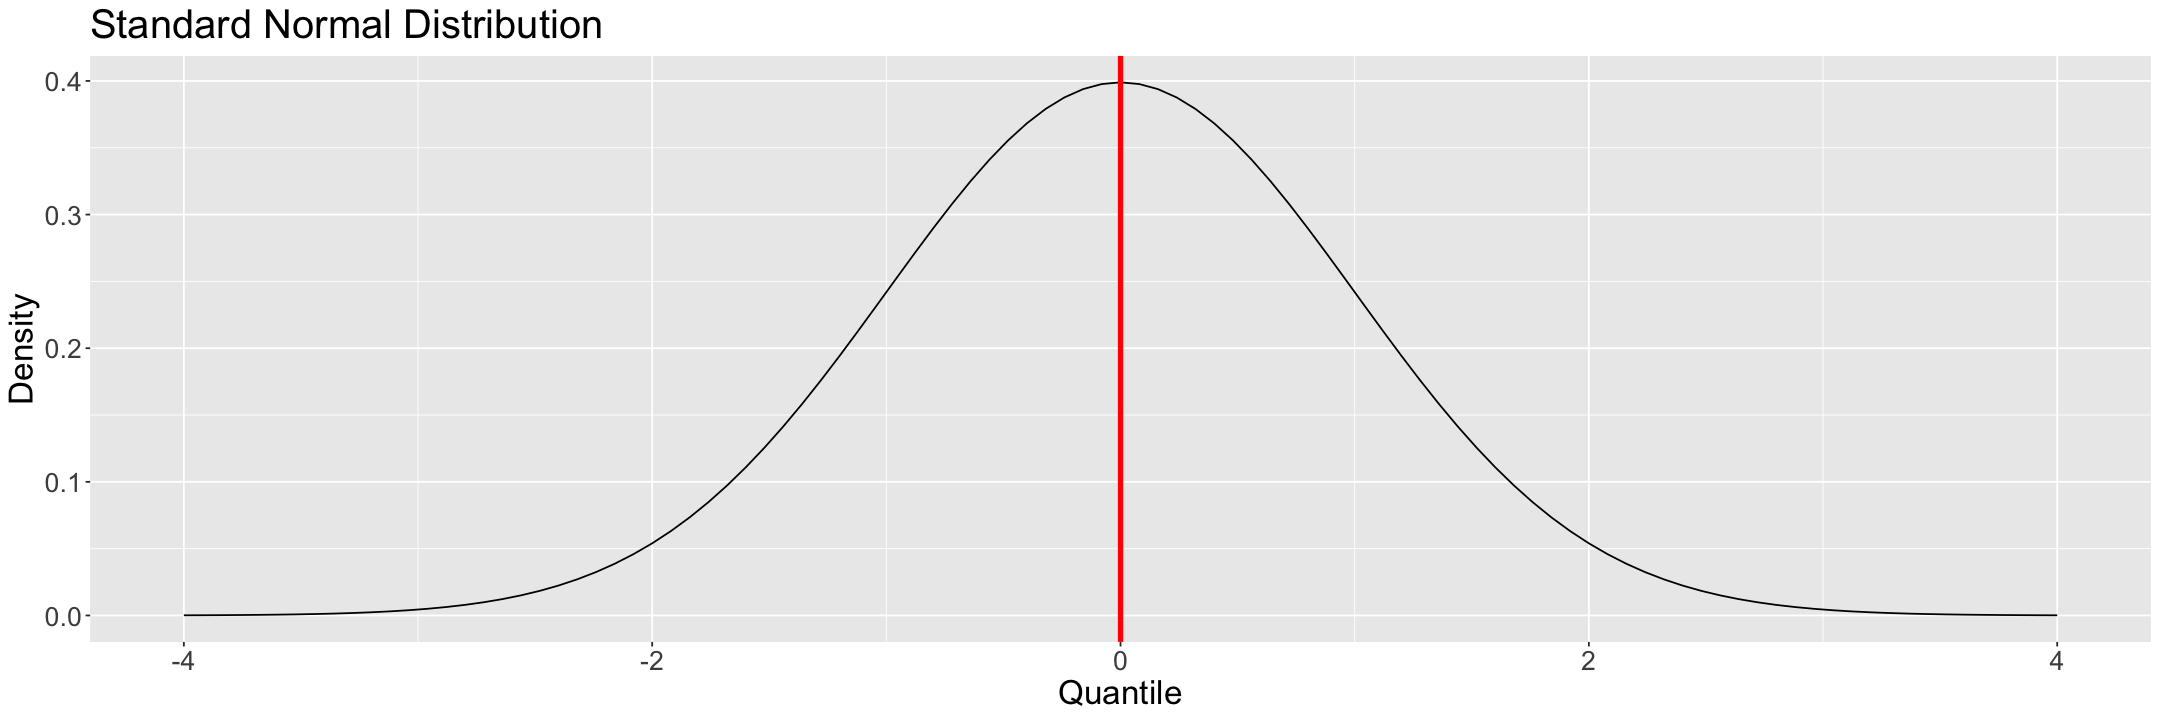

In [16]:
options(repr.plot.width = 18, repr.plot.height = 6) 

ggplot(data = data.frame(x = c(-4, 4)), aes(x)) +
  stat_function(fun = dnorm, n = 101, args = list(mean = 0, sd = 1)) +
  ylab("") +
  xlab("") +
  theme(text = element_text(size = 20)) +
  geom_vline(xintercept = 0, colour = "red", size = 1.5) +
  labs(x = "Quantile", y = "Density") +
  ggtitle("Standard Normal Distribution")

**Transforming the Standard Normal distribution...**

```{figure} img/normal.png
:height: 300px
:name: normal_dist

Image from [*Data Science Course in a Box*](https://github.com/rstudio-education/datascience-box).
```

Now, we know from CLT (and simulation!) that our sampling distribution should not be centred at 0, nor should it have a standard error of 1, but this is a good starting point. We can use this as a base and then use the information from our sample to shape it (i.e., determine its center and spread via $\mu$ and $\sigma$ respectively).

### 2.4. Equation for Confidence Intervals using the CLT

1. According to your $(1 - \alpha) \times 100\%$ confidence level of interest, find exact value of the quantile from the Standard Normal distribution.
2. Given a standard error ($\text{SE}$), the confidence interval equation is given by:

$$\text{Confidence Interval } = \text{Point Estimate} \pm  \underbrace{\, Z_{1 - \alpha/2} \, \times \, \text{SE}}_{\text{MoE}}.$$

```{attention}
The margin of error is defined as: $\text{MoE} = Z_{1 - \alpha/2} \, \times \, \text{SE}.$
```

Let us obtain the critical value $Z_{1 - \alpha/2}$ for a 95% confidence interval (i.e., $\alpha = 0.05$):

In [17]:
round(qnorm(0.025), 2)
round(qnorm(0.975), 2)

[1] -1.96

[1] 1.96

For a 95% confidence interval, this equation becomes:

$$\text{95% Confidence Interval } = \text{Point Estimate} \pm  \underbrace{\, 1.96 \, \times \, \text{SE}}_{\text{MoE}}.$$

```{important}
Recall the Standard Normal distribution is symmetrical, thus $Z_{1 - \alpha/2} = |Z_{\alpha/2}|$.
```

### 2.5. Confidence Interval for Continuous Cases

Note we need to define $\text{SE}$:

$$\text{Confidence Interval } = \text{Point Estimate} \pm  \underbrace{\, Z_{1 - \alpha/2} \, \times \, \text{SE}}_{\text{MoE}}.$$

From the CLT definition, the **standard error** would be:

$$\text{SE} = \frac{\hat{\sigma}}{\sqrt{n}}.$$

Nevertheless, we need the estimate $\hat{\sigma}$!

We might say: 

> *Let us just use the sample standard deviation $s$*. 

But, **we have to be careful on this decision** since we might need to use the $t$-distribution in a continuous case and not the Standard Normal (especially with a not too large $n$). So, we will explore the $t$-distribution approach in `lecture6`.

**In general for continuous sample means**, if we know the population $\sigma$:

- If the sample is small ($n < 30$), we cannot invoke the CLT. In this case, the sample observations **must** come from a Normal population (we can run a goodness-of-fit test such as Shapiro-Wilks to assess normality, for instance).

```{attention} 
If we know our sample comes from a Normal population, we will not even need the CLT regardless of the sample size!
```

- We can relax this condition more and more for larger and larger sample sizes ($n > 30$), since we can use the CLT in those large-sample cases.

### 2.6. Confidence Interval for Proportions

Recall the $i$th Bernoulli-type random variable can take on the following values:

$$
X_i =
\begin{cases}
1 \; \; \; \; \text{if we obtain a "success"},\\
0 \; \; \; \; \mbox{otherwise}.
\end{cases}
$$

#### 2.6.1. What is the population parameter in this case?

It is the probability of "success" $p$ (we can also use the greek letter $\pi$, as previously discussed). Therefore, the $i$th random variable can be expressed as:

$$X_i \sim \text{Bernoulli}(p).$$

```{important}
Another distributional result indicates that the sum $Y$ of $n$ *iid* Bernoulli random variables is distributed as: $Y = \sum_{i = 1}^n X_i \sim \text{Binomial}(n, p).$
```

Then, given the definition of Bernoulli-distributed $X_i$s, can the CLT apply to the sampled proportion $\hat{p}$?

$$\hat{p} = \frac{\sum_{i = 1}^n X_i}{n}$$

#### Yes, it can! We can see that $\hat{p}$ is merely a sample mean.

#### 2.6.2. Rules of Thumb for the CLT with Proportions

For sample proportion estimates $\hat{p}$, the sample size must be sufficiently large such that $\underbrace{n\hat{p}}_{\text{successes}} ≥ 10$ and $\underbrace{n(1 − \hat{p})}_{\text{failures}} ≥ 10$.

#### 2.6.3. The components of the confidence interval (CI) for proportions

$$\text{95% Confidence Interval } = \text{Point Estimate} \pm  \underbrace{\, 1.96 \, \times \, \text{SE}}_{\text{MoE}}.$$

Recall we use a single equation to obtain the confidence interval for the population proportion $\mu = p$ by applying the CLT. With a sample size $n$, we need the following:

- Our **point estimate** will be the **observed proportion** $\hat{p}$ (the unbiased estimator of the probability of success $p$). Since $\mathbb{E}({X_i}) = p$, it follows that

$$\mathbb{E}\big( \hat{p} \big) = \mathbb{E} \Bigg( \frac{\sum_{i = 1}^n X_i}{n}\Bigg) = p.$$

- Assuming $X_1, \dots, X_n$ are **independent** and $\text{Var}({X_i}) = p (1 - p)$ (since they are Bernoulli random variables) we know that 

$$\text{Var} \big( \hat{p} \big) = \text{Var}\Bigg( \frac{\sum_{i = 1}^n X_i}{n}\Bigg) = \frac{p (1 - p)}{n}.$$

- How can we estimate $\sqrt{\text{Var} \big( \hat{p} \big)}$? We can use the information provided by our sample in the form of the **standard error $\text{SE}$ for proportions**:

$$\text{SE} = \sqrt{\frac{\hat{p} (1 - \hat{p})}{n}}.$$

- Finally, we also need the critical value $Z_{1 - \alpha /2}$ where $\alpha$ is the significance level yielding a confidence of $(1 - \alpha) \times 100\%$. This critical value is a quantile coming from the Standard Normal distribution.

### 2.7. Example: Confidence intervals for our A/B testing case

Let us retake the context from `lecture4`, but now under a classical inferential approach.

```{figure} img/ab_test2.png
:height: 400px
:name: ab_webpage_2_b

*Image from <a href="https://quod.lib.umich.edu/w/weave/12535642.0001.101?view=text;rgn=main">Young (2014).*
```

#### 2.7.1. How do we compute a click-through-rate (CTR)?

Recall a CTR can be computed as a proportion. Therefore, note the following:

$$\text{CTR}_i = \frac{\text{Total number of clicks on the button of interest in the $i$th page}}{\text{Total number of impressions on the $i$th page}}$$

This response in the experiment is a proportion. Therefore:

- $p_I \in [0,1]$ is the CTR of the *Interact* (control) treament. 
- $p_S \in [0,1]$ is the CTR of the *Services* (variation) treament. 

#### 2.7.2. Loading the Experimental Data Set

Let us start with loading the same data set from `lecture4`. Recall that each row represents an **experimental unit** (i.e., webpage visitors who are part of the A/B testing). They were randomized to either treatment `Services` or `Connect` (column `webpage`). Finally, our outcome of interest is column `click_target` (whether the experimental unit clicked or not on the link of interest, i.e., a Bernoulli trial).

In [18]:
click_through <- read_csv("data/click_through.csv")
click_through

Rows: 3722 Columns: 2
── Column specification ────────────────────────────────────────────────────────────
Delimiter: ","
chr (1): webpage
dbl (1): click_target

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


webpage,click_target
<chr>,<dbl>
Services,0
Interact,0
Services,0
⋮,⋮
Interact,0
Services,0
Services,0


#### 2.7.3. Can we use the CLT to calculate confidence intervals by experimental treatment?

Let us check whether we fulfill the required conditions:

**Are the observations independent?**

> Yes, they are! The experimenters used Google Analytics to randomly serve up the different versions of the websites to people visiting the website ([source](https://quod.lib.umich.edu/w/weave/12535642.0001.101?view=text;rgn=main)).

For the $i$th experimental treatment, **is the sample size sufficiently large such that $n_i \hat{p}_i ≥ 10$ (column `successes`) and $n_i (1 − \hat{p}_i) ≥ 10$ (column `failures`)?**

> Yes, it is! Let us check the code below.

In [19]:
click_through %>%
  group_by(webpage) %>%
  summarize(
    prop = sum(click_target) / n(),
    successes = prop * n(),
    failures = n() * (1 - prop)
  )

webpage,prop,successes,failures
<chr>,<dbl>,<dbl>,<dbl>
Interact,0.02847709,69,2354
Services,0.04849885,63,1236


#### 2.7.4. Let us calculate the standard error!

For the $i$th experimental treatment, the standard error is:

$$\text{SE}_i = \frac{\hat{\sigma}_i}{\sqrt{n_i}},$$

where

- $\hat{\sigma}_i$ is the estimate of the treatment's population standard deviation $\sigma_i$, and
- $n_i$ is the number of observations in our sample per treatment.

For a sample proportion, $\hat{\sigma}_i = \sqrt{\hat{p}_i (1 - \hat{p}_i)}$. Thus:

$$\text{SE}_i = \sqrt{\frac{\hat{p}_i (1 - \hat{p}_i)}{n_i}}.$$

To calculate a confidence interval for the $i$th proportion using the CLT, we need the following:

- $\hat{p}_i$.
- $n_i$.
- $\text{SE}_i$.
- Our critical value $Z_{1 - \alpha/2}$

Let us compute the first three:

In [20]:
click_through_est <- click_through %>%
  group_by(webpage) %>%
  summarize(
    click_rate = sum(click_target) / n(),
    n = n()
  ) %>%
  mutate(se = sqrt(click_rate * (1 - click_rate) / n))
click_through_est

webpage,click_rate,n,se
<chr>,<dbl>,<int>,<dbl>
Interact,0.02847709,2423,0.003379074
Services,0.04849885,1299,0.005960268


#### 2.7.5. Now, we calculate the 95% confidence intervals...

We apply the so-called formula:

$$\text{95% Confidence Interval } = \text{Point Estimate} \pm  \underbrace{\, 1.96 \, \times \, \text{SE}}_{\text{MoE}}$$

In [21]:
click_through_CLT_95_ci <- click_through_est %>%
  mutate(
    lower_95 = click_rate - (qnorm(0.975) * se),
    upper_95 = click_rate + (qnorm(0.975) * se),
    Method = rep("CLT", 2)
  )
click_through_CLT_95_ci

webpage,click_rate,n,se,lower_95,upper_95,Method
<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>
Interact,0.02847709,2423,0.003379074,0.02185423,0.03509996,CLT
Services,0.04849885,1299,0.005960268,0.03681693,0.06018076,CLT


What if we wanted to calculate 90% confidence intervals (i.e., $\alpha = 0.10$)?

In [22]:
round(qnorm(0.05), 2)
round(qnorm(0.95), 2)

[1] -1.64

[1] 1.64

The quantile will change to $1.64$, since we would have to adjust the corresponding level of confidence.

$$\text{90% Confidence Interval } = \text{Point Estimate} \pm  \underbrace{\, 1.64 \, \times \, \text{SE}}_{\text{MoE}}.$$

In [23]:
click_through_est %>%
  mutate(
    lower_90 = click_rate - (qnorm(0.95) * se),
    upper_90 = click_rate + (qnorm(0.95) * se), 
  )

webpage,click_rate,n,se,lower_90,upper_90
<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
Interact,0.02847709,2423,0.003379074,0.02291901,0.03403518
Services,0.04849885,1299,0.005960268,0.03869508,0.05830261


#### 2.7.6. What if we compare the CLT-based 95% confidence intervals versus the ones obtained via bootstrapping?

Let us re-run the bootstrapping code from our previous lecture with $b = 1,000$ replicates.

In [24]:
click_through <- click_through %>%
  mutate(
    click_target = factor(click_target), webpage = factor(webpage)
  )

set.seed(1234) # For reproducibility.
interact_boot_95_ci <- click_through %>%
  filter(webpage == "Interact") %>%
  specify(response = click_target, success = "1") %>%
  generate(reps = 1000, type = "bootstrap") %>%
  calculate(stat = "prop") %>%
  get_ci()
interact_boot_95_ci$webpage <- "Interact"
interact_boot_95_ci$Method <- "Bootstrapping"

set.seed(1234) # For reproducibility.
services_boot_95_ci <- click_through %>%
  filter(webpage == "Services") %>%
  specify(response = click_target, success = "1") %>%
  generate(reps = 1000, type = "bootstrap") %>%
  calculate(stat = "prop") %>%
  get_ci()
services_boot_95_ci$webpage <- "Services"
services_boot_95_ci$Method <- "Bootstrapping"

click_through_boot_95_ci <- rbind(interact_boot_95_ci, services_boot_95_ci)

Finally, we compare both approaches:

In [25]:
click_through_CLT_95_ci
click_through_boot_95_ci

webpage,click_rate,n,se,lower_95,upper_95,Method
<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>
Interact,0.02847709,2423,0.003379074,0.02185423,0.03509996,CLT
Services,0.04849885,1299,0.005960268,0.03681693,0.06018076,CLT


lower_ci,upper_ci,webpage,Method
<dbl>,<dbl>,<chr>,<chr>
0.02227610,0.03467809,Interact,Bootstrapping
0.03693226,0.06004619,Services,Bootstrapping


#### 2.7.7. What has changed now that we are using the CLT?

We are using mathematically defined distributions instead of a simulation-based approach. For confidence intervals, we are using mathematical shortcuts to calculate the plausible range instead of just reading the values off the bootstrap distribution.

#### 2.7.8. When to use what?

- If computational speed does not matter, and you do not violate any of the conditions of the CLT, then you can either use a simulation-based approach (like bootstrapping) or CLT, and you will get essentially the same results.
- If you are violating the conditions of the CLT, then you might want to use simulation-based approaches. But remember, there is no free lunch! For example, if your sampling is of terrible quality, simulation-based approaches will give you an answer, but it will not be very accurate.

## 3. What is next?

- Hypothesis testing based on normal and $t$-distributions.

## 4. Acknowledgements

- [Open Intro Statistics](https://www.openintro.org/book/os/) by David Diez, Mine Cetinkaya-Rundel and Christopher D Barr
- [Data Science in a box](https://github.com/rstudio-education/datascience-box) by Mine Cetinkaya-Rundel
- [Inference in 3 hours](https://github.com/AllenDowney/CompStats) by Allan Downey
- [Modern Dive: An Introduction to Statistical and Data Sciences via R](https://moderndive.com/index.html) by Chester Ismay and Albert Y. Kim